**DataSet Import**

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'metagenomics:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1035997%2F1745083%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T152828Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3De68d8197f0e3e9eb97d39ee24e0aa720d8f592c1d01d8e269c8971c78af162d533450f36f15985d82b28875ead0e3f00aac1c67d1738363f9e777eb3000f5604af24fc5f36fb3cf8d12f17e61fd94bb90f74efa3fa1529fa0ae9360f0b7ef0c4a6411e0fa5c2aa67d2f5c8c59f91cd58441214b0f876b0b13c7ea8ef1c44008496237b8a8411351262861b4e49226e939de289446b0e1809d3e57a80a270b478324c1382cf11fc4b471a645db8aeb782680729b6eb99a1c5f3d526903b610b38defcb24ffda403e3eaea02d9262f076dd62c077f86b008d50ca4640540960bc34f993f1e69446601bd3f67a81ae8242c02af4abd605df5b856747e1d94c2cac1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 83455861 bytes downloaded
Downloaded and uncompressed: metagenomics
Data source import complete.


**Libraries**

In [4]:
!pip install scikit-plot


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import is_numeric_dtype

import os

from xgboost import XGBClassifier
import xgboost as xgb

import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score

import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

**Metaparameters**

In [6]:
VERBOSE = 0
FOLDS = 10
test_train_split_SEED = 1971

In [8]:
def  file_to_dataframe(file):
    df = pd.read_csv(file,sep="\t",dtype=object,header=None, na_values='nd').T

    header = df.iloc[0]
    df = df[1:] #take the data less the header row
    df.columns = header

    return(df)
pd_abundance = file_to_dataframe('../input/metagenomics/abundance_stoolsubset.txt')

In [9]:
disease = pd_abundance.loc[:,'disease']
d_name = pd_abundance.loc[:,'dataset_name']
print(disease.value_counts())

# list of diseases we want to analyze and predict
diseases = ['obesity', 'cirrhosis', 't2d', 'cancer']

disease
n                             944
t2d                           223
obesity                       164
ibd_ulcerative_colitis        148
cirrhosis                     118
leaness                        89
stec2-positive                 52
impaired_glucose_tolerance     49
cancer                         48
n_relative                     47
small_adenoma                  26
ibd_crohn_disease              25
 -                             20
large_adenoma                  13
overweight                     10
-                               7
obese                           5
underweight                     1
Name: count, dtype: int64


**Modelling**

In [10]:
cols = pd_abundance.columns.tolist()
species = [x for x in cols if x.startswith('k_')]
metadata = [x for x in cols if not x.startswith('k_')]


pd_abundance_conv = pd_abundance.copy()
pd_abundance_conv = pd_abundance_conv[species].astype('float64')
pd_abundance_conv = pd.concat([pd_abundance[metadata], pd_abundance_conv], axis = 1)

# controls/healthy samples from Human Microbiome Project coded 'hmp' and 'hmpii'.
# 't2d' stands for Type 2 Diabetes. We will combine a few studies into single dataset.
data_sets = {'control':['hmp', 'hmpii'],'t2d':['WT2D','t2dmeta_long','t2dmeta_short'], 'cirrhosis' : ['Quin_gut_liver_cirrhosis'],
             'cancer' : ['Zeller_fecal_colorectal_cancer'], 'obesity' : ['Chatelier_gut_obesity']}
# combine controls from different studies into one
pd_abundance_conv['disease'] = pd_abundance_conv['disease'].apply(lambda x: 'control' if ((x == 'n') or (x == 'nd') or (x == 'leaness')) else x)

# change some metadata variables to numeric
pd_abundance_conv['age'] = pd.to_numeric(pd_abundance_conv.age,  errors='coerce')
pd_abundance_conv['gender'] = pd_abundance_conv['gender'].astype('category').cat.codes
pd_abundance_conv['country'] = pd_abundance_conv['country'].astype('category').cat.codes

for col in metadata:
    pd_abundance_conv[col] = pd.to_numeric(pd_abundance_conv[col],  errors='ignore')

numeric_metadata = [c for c in metadata if is_numeric_dtype(pd_abundance_conv[c]) ]

# also add other features


# separate controls and diseases into 2 dataframes
pd_control = pd_abundance_conv.loc[pd_abundance_conv['disease'] == 'control']
pd_disease = pd_abundance_conv.loc[pd_abundance_conv['disease'] != 'control']

# we won't consider diseases from this list
not_disease = [d for d in pd_disease.disease.unique().tolist() if d not in diseases]
for d in not_disease:
    pd_disease = pd_disease.drop(pd_disease.loc[pd_disease['disease'] == d].index, axis = 0)

SEED = 42
d = 't2d'
import warnings
warnings.filterwarnings("ignore")

In [13]:
def disease_prediction(d, species):
    print('-' * 80)
    print('Disease : %s'%d)

    skf = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
    oof_preds = []
    oof_aucs = []
    oof_scores= []
    ds_names = data_sets[d]
    if len(ds_names) == 1:
        pd_cont = pd_control.loc[pd_control['dataset_name'] == ds_names[0]]
        pd_dis = pd_disease.loc[pd_disease['dataset_name'] == ds_names[0]]
    else:
        pd_cont = pd_control.loc[pd_control['dataset_name'] == ds_names[0]]
        pd_dis = pd_disease.loc[(pd_disease['disease'] == d) & (pd_disease['dataset_name'] == ds_names[0])]
        for ds in ds_names[1:]:
            pd_cont = pd.concat([pd_cont, pd_control.loc[pd_control['dataset_name'] == ds]], axis = 0)
            pd_dis = pd.concat([pd_dis, pd_disease.loc[(pd_disease['disease'] == d) & (pd_disease['dataset_name'] == ds)]], axis = 0)

    #     create dataset with all other diseases, target set to 0
    pd_others = pd_disease.loc[(pd_disease['disease'] != d)]
    target_others = pd_others['disease'].apply(lambda x: 1 if x == d else 0)

    #     combine controls and this particular disease back into train dataset
    pd_train = pd.concat([pd_cont, pd_dis], axis = 0)

    #     adding control data from healthy subject, data by HMP
    pd_train = pd.concat([pd_train, pd_control.loc[pd_control['dataset_name'] == 'hmp']], axis = 0)
    pd_train = pd.concat([pd_train, pd_control.loc[pd_control['dataset_name'] == 'hmpii']], axis = 0)

    target = pd_train['disease']
    # convert text target into binary
    binary_target = target.apply(lambda x: 1 if x == d else 0)
    # binary_target.value_counts()
    pd_others = pd_others[species]
    pd_train  = pd_train[species]
    # this split provides us with preserved test set
    disease_train, disease_test, disease_y_train, disease_y_test = train_test_split(pd_train, binary_target, test_size = 0.10, #stratify = binary_target,
                                                                                    random_state = test_train_split_SEED)

    #     combining preserved test set with othere diseases samples
    full_test = pd.concat([disease_test, pd_others])
    full_y_test = pd.concat([disease_y_test, target_others])

    disease_y_test.value_counts()
    disease_y_train.value_counts()
    preds = np.zeros(disease_y_test.shape[0])
    full_preds = np.zeros(full_y_test.shape[0])

    for fold, (idxT,idxV) in enumerate(skf.split(disease_train, disease_y_train)):

        X_train = disease_train.iloc[idxT]
        X_val = disease_train.iloc[idxV]
        y_train = disease_y_train.iloc[idxT]
        y_val = disease_y_train.iloc[idxV]

        XGB_model = XGBClassifier(n_estimators=5000, max_depth=None,
                            learning_rate=0.05,
                            objective='binary:logistic',
                            metric='auc',
                            verbosity  = VERBOSE,
                            n_jobs=-1, random_state  = SEED)


        XGB_model.fit(X_train, y_train,
                        eval_set = [(X_val, y_val)],
                        eval_metric=['logloss'],
                        # eval_metric=['auc','logloss'],
                        early_stopping_rounds = 100, verbose = VERBOSE )

        XGB_preds = XGB_model.predict_proba(X_val)
        XGB_score = metrics.roc_auc_score(y_val, XGB_preds[:,1])
        XGB_class = XGB_model.predict(X_val)

        XGB_test = XGB_model.predict_proba(disease_test)
        XGB_test_score = metrics.roc_auc_score(disease_y_test, XGB_test[:,1])
        XGB_test_class = XGB_model.predict(disease_test)

        full_test_preds = XGB_model.predict_proba(full_test)
        full_test_score = metrics.roc_auc_score(full_y_test, full_test_preds[:,1])
        full_test_class = XGB_model.predict(full_test)

        f1s = f1_score(y_val, XGB_class)
        recall = metrics.recall_score(y_val, XGB_class)
        precision_score = metrics.precision_score(y_val, XGB_class)

        f1_test = f1_score(disease_y_test, XGB_test_class)
        recall_test = metrics.recall_score(disease_y_test, XGB_test_class)
        precision_score_test = metrics.precision_score(disease_y_test, XGB_test_class)

        f1_full_test = f1_score(full_y_test, full_test_class)
        recall_full_test = metrics.recall_score(full_y_test, full_test_class)
        precision_full_test = metrics.precision_score(full_y_test, full_test_class)


        preds += XGB_test[:,1] / FOLDS
        full_preds += full_test_preds[:,1] / FOLDS

        fold_score = [XGB_score,f1s,recall,precision_score, XGB_test_score,f1_test,recall_test,precision_score_test]
        oof_scores.append({fold : fold_score})

    avg_test_score = metrics.roc_auc_score(disease_y_test, preds)
    avg_class = np.where(preds < 0.5, 0, 1)
    avg_f1_test = f1_score(disease_y_test, avg_class)
    avg_recall_test = metrics.recall_score(disease_y_test, avg_class)
    avg_precision_score_test = metrics.precision_score(disease_y_test, avg_class)

    avg_full_test_score = metrics.roc_auc_score(full_y_test, full_preds)
    avg_class_full = np.where(full_preds < 0.5, 0, 1)
    avg_f1_test_full = f1_score(full_y_test, avg_class_full)
    avg_recall_full_test = metrics.recall_score(full_y_test, avg_class_full)
    avg_precision_full_test = metrics.precision_score(full_y_test, avg_class_full)

    print('-' * 80)
    print('Averaged over %i folds ROC AUC score for %s: %.4f'%(FOLDS,d,avg_test_score))
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(avg_f1_test, avg_recall_test, avg_precision_score_test))
    print('Confusion matrix for %s averaged across %i folds '%(d,FOLDS))
    print(confusion_matrix(disease_y_test, avg_class))


    print('Averaged over %i folds ROC AUC score for %s against full set of other diseases: %.4f'%(FOLDS,d,avg_full_test_score))
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(avg_f1_test_full, avg_recall_full_test, avg_precision_full_test))
    print('Confusion matrix for %s averaged across %i folds for full set'%(d,FOLDS))
    print(confusion_matrix(full_y_test, avg_class_full))

    return preds, disease_y_test, full_preds, full_y_test, XGB_model

In [14]:
d_pred, y_true, full_preds, full_y_test, last_model = disease_prediction(d, species)

--------------------------------------------------------------------------------
Disease : t2d
--------------------------------------------------------------------------------
Averaged over 10 folds ROC AUC score for t2d: 0.8712
F1 : 0.5143, Recall : 0.4091 , Precision : 0.6923
Confusion matrix for t2d averaged across 10 folds 
[[38  4]
 [13  9]]
Averaged over 10 folds ROC AUC score for t2d against full set of other diseases: 0.6805
F1 : 0.1304, Recall : 0.4091 , Precision : 0.0776
Confusion matrix for t2d averaged across 10 folds for full set
[[265 107]
 [ 13   9]]


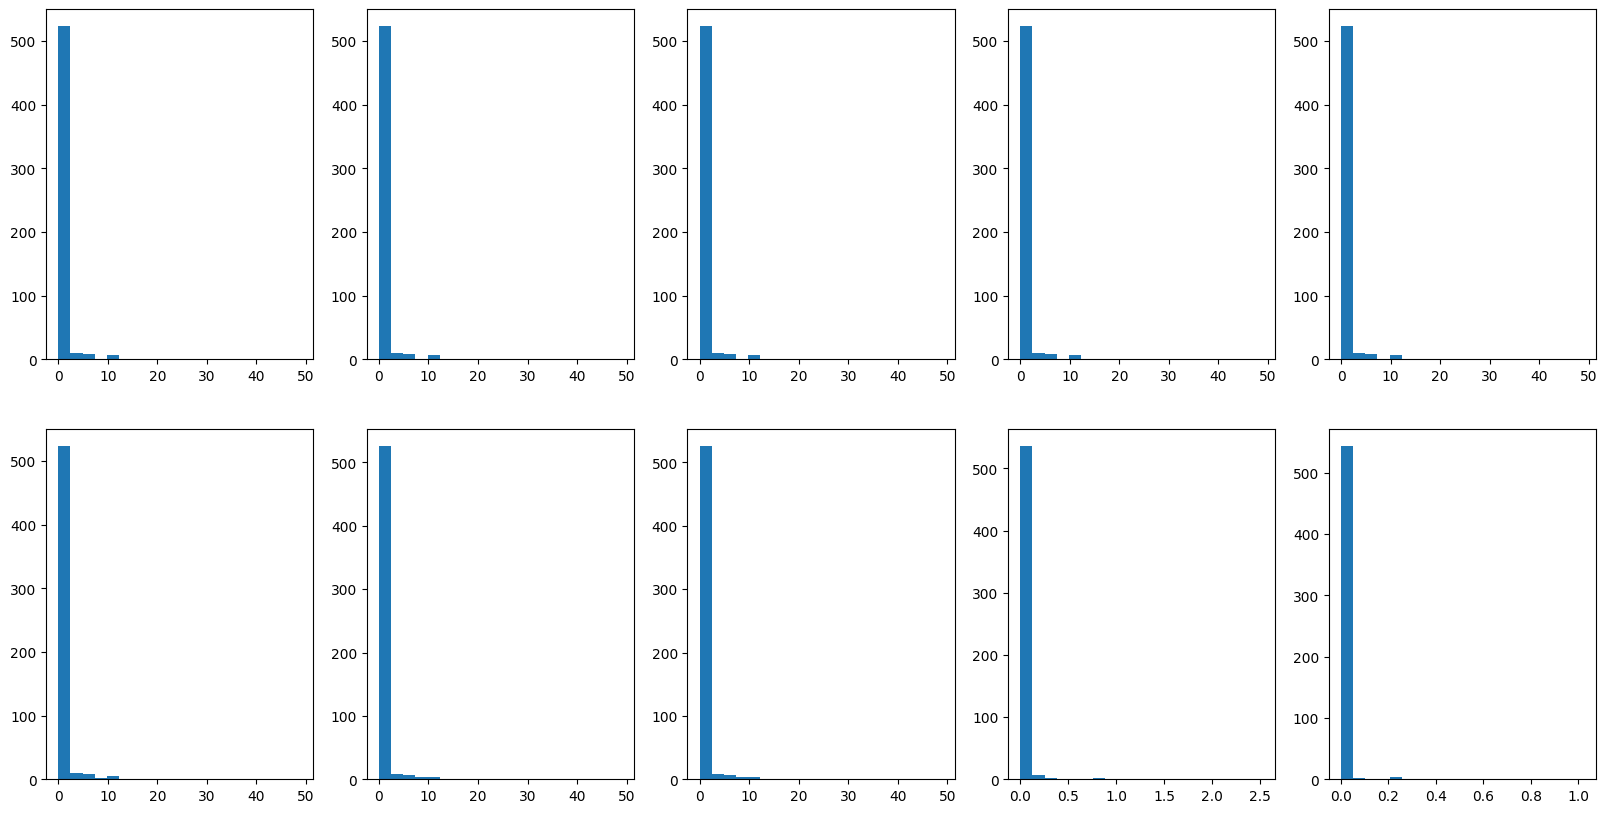

In [15]:
plt.figure(figsize=(20,10))
for f in range(10):
    plt.subplot(2, 5, f+1)
    plt.hist(pd_disease[species[f]], bins=20)

(array([1.901e+03, 7.900e+01, 5.900e+01, 2.500e+01, 2.400e+01, 8.000e+00,
        1.000e+01, 5.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00]),
 array([ 0.        ,  1.07344666,  2.14689331,  3.22033997,  4.29378662,
         5.36723328,  6.44067994,  7.51412659,  8.58757325,  9.6610199 ,
        10.73446656, 11.80791322, 12.88135987, 13.95480653, 15.02825319,
        16.10169984, 17.1751465 , 18.24859315, 19.32203981, 20.39548647,
        21.46893312]),
 <BarContainer object of 20 artists>)

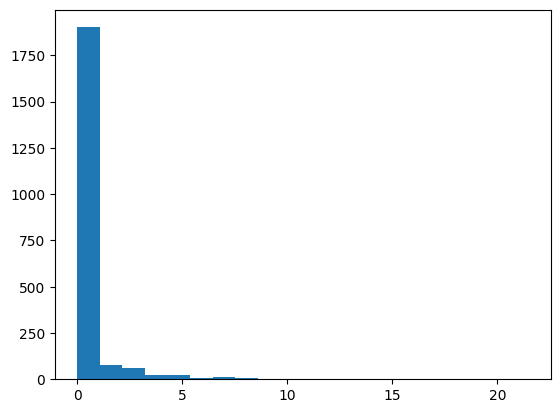

In [16]:
plt.hist(pd_disease[species].std(), bins=20)

In [17]:
# Select species with abundance whose std is larger than 2
new_species = np.array(species)[pd_disease[species].std().values>2]
d_pred, y_true, full_preds, full_y_test, last_model = disease_prediction(d, new_species)

--------------------------------------------------------------------------------
Disease : t2d
--------------------------------------------------------------------------------
Averaged over 10 folds ROC AUC score for t2d: 0.8864
F1 : 0.7500, Recall : 0.6818 , Precision : 0.8333
Confusion matrix for t2d averaged across 10 folds 
[[39  3]
 [ 7 15]]
Averaged over 10 folds ROC AUC score for t2d against full set of other diseases: 0.8023
F1 : 0.2344, Recall : 0.6818 , Precision : 0.1415
Confusion matrix for t2d averaged across 10 folds for full set
[[281  91]
 [  7  15]]


In [18]:
# add other features
features = np.hstack([new_species, 'age', 'country', 'gender','birth_year', 'cholesterol', 'fasting_insulin',
                      'hypertension', 'sepsis', 'creatinine', 'triglycerides'])
# These features have some missing values but xgboost can handle it
d_pred, y_true, full_preds, full_y_test, last_model = disease_prediction(d, features)

--------------------------------------------------------------------------------
Disease : t2d
--------------------------------------------------------------------------------
Averaged over 10 folds ROC AUC score for t2d: 0.9470
F1 : 0.8372, Recall : 0.8182 , Precision : 0.8571
Confusion matrix for t2d averaged across 10 folds 
[[39  3]
 [ 4 18]]
Averaged over 10 folds ROC AUC score for t2d against full set of other diseases: 0.8280
F1 : 0.2466, Recall : 0.8182 , Precision : 0.1452
Confusion matrix for t2d averaged across 10 folds for full set
[[266 106]
 [  4  18]]
